# MMSR Analytics, lab 1: Reranking features

This week, we are going to investigate visual reranking features for image sets.

In this, we will look at some of the features proposed in the paper 'Supervised Reranking for Web Image Search' by Yang and Hanjalic, 2010. You can find this paper through Blackboard and through https://people.cs.clemson.edu/~jzwang/ustc13/mm2010/p183-yang.pdf. You are strongly encouraged to have it at hand while performing the assignments. 

We will focus in particular on assessing various neighborhood rank voting mechanisms based on <i>k</i>-nearest neighbors (Section 4.1 in the paper). For this, we use a (very small) subset of the MSRA-MM dataset that also was referred to in the paper.

Note that this only considers a small part (and as said, a small sample) of the actual paper; if you want to fully apply visual learning-to-rerank, you will need a much bigger training data set, and tune various parameters, which would be out of scope for a lab. The present assignment should still give you a more concrete feel of how voting mechanisms based on visual features work though.

## Your assignment
To demonstrate your completed assignment, please submit a file named [studentNumberMember1_studentNumberMember2.pdf] through https://www.dropbox.com/request/VAtbfIcHLxxv8tWJiRIC . In this file, discuss your observations on how neighborhood voting mechanisms affect the ranking of images in the lab dataset. More specifically, focus on discussing the following questions:
- what is the impact of changing <i>k</i>?
- what is the impact of considering different visual features to base comparison on (i.e. edge histograms vs. HSV histograms)?
- what voting mechanisms strike you as particularly good or bad for the given image categories?
- do you notice major differences between different image categories, and can you explain these?

Please give at least 3 concrete examples supporting your answers, providing images or screenshots of results.

## Importing the necessary Python modules

We import several modules. You may recognize some of these from the first lab, as we also were considering image ranking back then.

In [1]:
# Import standard Python modules.
import numpy as np
import os
import sys

# Import extra Python modules.
import matplotlib.pyplot as plt
# Make matplotlib plot inline
%matplotlib inline 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from cvtools import ipynb_show_cv2_image
import cv2

from datasets import CS4065_Dataset

## Importing data
Now we import our dataset for this lab.

In [2]:
msra_mm1_data = CS4065_Dataset.get_msra_mm1_subset()

## About the data
The data is taken from the MSRA-MM (v1.0) dataset. This dataset consists of ranked retrieval results for various query categories, and precomputed features.

The dataset is not publicly available anymore, and as it is several years old, not all images are available online anymore. In our lab, we made a selection of five query categories ('angel', 'animals', 'baseball', 'beach', 'bees'), and for each of these, we include 30-40 images from the top of the original ranking which still can be crawled today.

For the visual features, we consider two types of precomputed features:
- a 64-dimensional HSV histogram ('HSV64'), reflecting color-related information;
- a 75-dimensional edge distribution histogram ('EDH75'), reflecting texture-related information.

The dataset in this lab has the form of a Python dictionary. Let's focus on the 'angel' category, and check what data is in the dictionary on this.

In [3]:
category = 'angel'

# show dictionary contents
category_data = msra_mm1_data[category]
print category_data

{'HSV64': array([[ 0.006335,  0.005896,  0.021777, ...,  0.011816,  0.004828,
         0.007195],
       [ 0.003228,  0.010944,  0.006137, ...,  0.01154 ,  0.006687,
         0.00321 ],
       [ 0.003586,  0.009007,  0.007084, ...,  0.01474 ,  0.006461,
         0.00377 ],
       ..., 
       [ 0.004897,  0.007004,  0.011808, ...,  0.012516,  0.005755,
         0.00548 ],
       [ 0.003537,  0.007564,  0.005043, ...,  0.007198,  0.009572,
         0.003813],
       [ 0.002791,  0.006011,  0.00343 , ...,  0.006959,  0.016987,
         0.003114]]), 'original_ranks': [0, 1, 2, 6, 10, 11, 15, 17, 18, 19, 21, 25, 31, 33, 36, 38, 39, 42, 43, 52, 54, 55, 56, 58, 59, 63, 68, 69, 72, 73, 75, 84, 89, 93, 96, 99, 100, 102], 'EDH75': array([[ 0.127568,  0.098442,  0.094604, ...,  0.133314,  0.11219 ,
         0.279189],
       [ 0.072614,  0.068714,  0.069793, ...,  0.109141,  0.094195,
         0.489572],
       [ 0.165447,  0.148926,  0.127213, ...,  0.226148,  0.081272,
         0.024735],
    

## Inspection
Verify there are 38 'angel' images in our dataset.

Note there are two ranking lists connected to the images:
- 'original_ranks' reflects the original position of each of the images in the original MSRA-MM dataset ranking for the 'angel' category. This ranking was based on textual search in a commercial search engine.
- 'initial_ranks' reflects the ranking position as we will use now. We start at rank 1, and simply count up. So even while the 5th image in the dataset was originally at position 10 (rank 11), as it is the fifth item we have available, we will just treat it as being on rank 5 in future computation.

Let's now also print the full ranked image list.

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


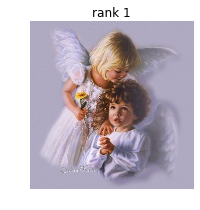

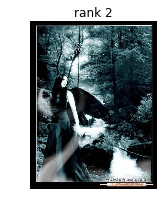

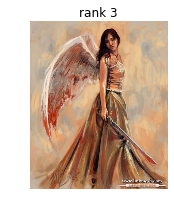

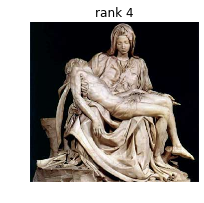

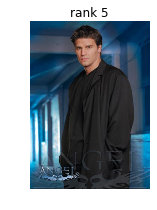

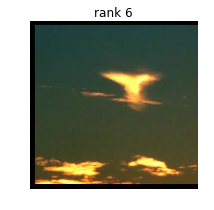

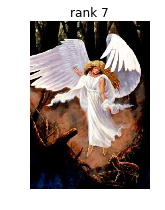

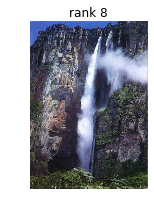

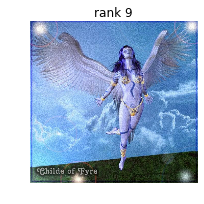

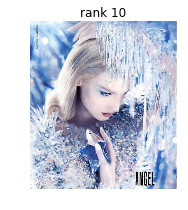

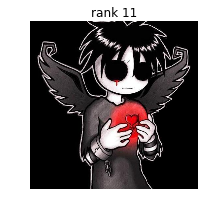

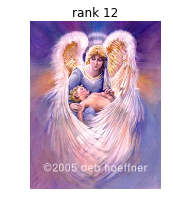

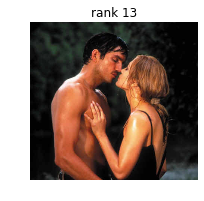

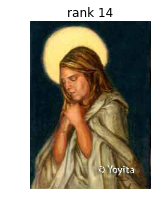

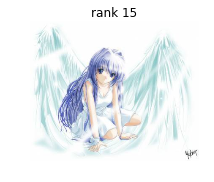

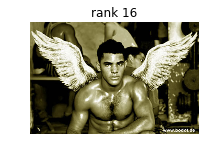

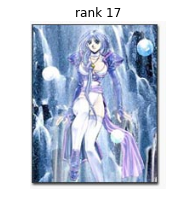

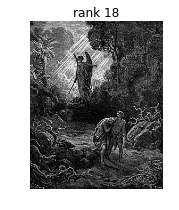

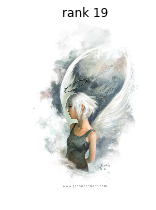

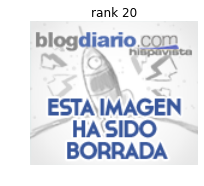

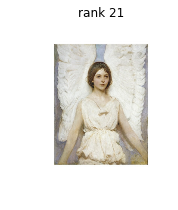

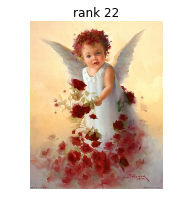

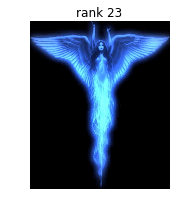

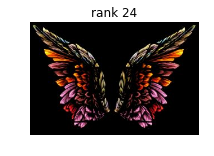

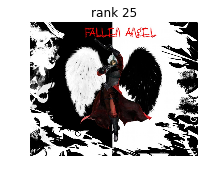

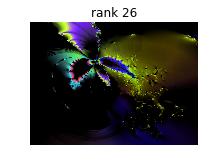

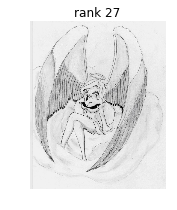

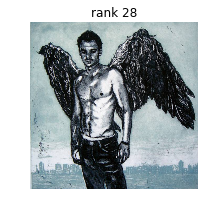

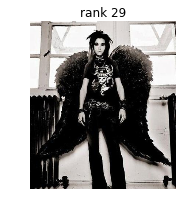

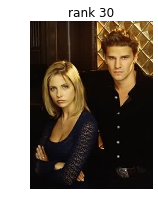

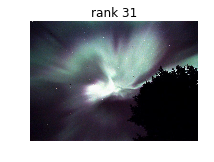

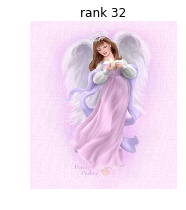

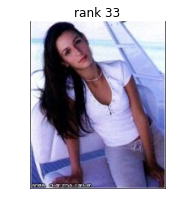

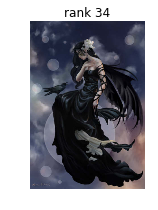

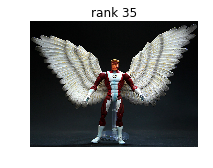

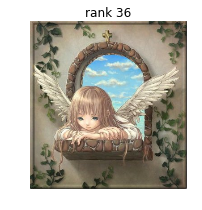

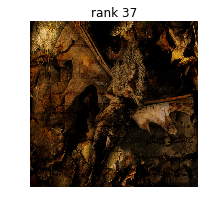

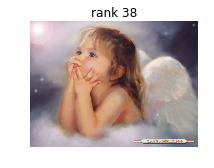

In [4]:
for index in range(len(category_data['initial_ranks'])):
    image_path = category_data['image_paths'][index]
    # print image_path
    image = cv2.imread(image_path)
    ipynb_show_cv2_image(image, 'rank %s' % category_data['initial_ranks'][index], (3, 3))

## Getting the neighborhoods for each item
For visual reranking, we now want to know what the visual neighbors of each of our items are.

The paper mentions three possible strategies (Section 4.1.1): <i>k</i>-nearest Neighbors, $\epsilon$-nearest neighbors, and a combination of both.

We will for the current lab only consider <i>k</i>. Note that this also is a parameter to be tuned. Initially, we will set it at 5, so for each of the images, we want to know the 5 closest visual neighbors.

In [5]:
# Set a value for k
k = 5

Now what are visual neighbors? As you learned throughout this course (and maybe in preceding Pattern Recognition courses), there are many possible ways to combine and weigh various features. As we only have few samples in the particular example of this lab though, we will for now treat our edge and HSV features separately (of course, you are welcome to try combining them in more sophisticated ways when experimenting towards your final deliverable report).

For the time being, let's consider the edge features, and make a distance matrix based on these between all images in our dataset. For the distance measure, we consider the Euclidean distance.

In [12]:
visual_features = category_data['EDH75']
edh_dist = squareform(pdist(visual_features, 'euclidean'))

# what are the dimensions of this matrix?
edh_dist

array([[ 0.        ,  0.65803404,  0.97143059, ...,  0.94660755,
         0.69644158,  0.56407083],
       [ 0.65803404,  0.        ,  1.06513685, ...,  0.814991  ,
         0.91077938,  0.65608111],
       [ 0.97143059,  1.06513685,  0.        , ...,  0.80655931,
         1.33652774,  0.97080136],
       ..., 
       [ 0.94660755,  0.814991  ,  0.80655931, ...,  0.        ,
         1.18901683,  0.83355518],
       [ 0.69644158,  0.91077938,  1.33652774, ...,  1.18901683,
         0.        ,  0.74574728],
       [ 0.56407083,  0.65608111,  0.97080136, ...,  0.83355518,
         0.74574728,  0.        ]])

Now, by using the distance matrix, let's find the closest neighbors of each of our images. For this, we use <code>np.argsort</code>, which sorts each row in ascending order, and gives column indices corresponding to this order.

In [7]:
best_neighbors = np.argsort(edh_dist)

In [8]:
print best_neighbors

[[ 0 22  9 ..., 24 25 20]
 [ 1 13 17 ..., 33 25 20]
 [ 2 35 32 ..., 28 23 25]
 ..., 
 [35  3 31 ..., 28 33 25]
 [36 16 26 ..., 18  3 20]
 [37 34 10 ..., 24 20 25]]


## Question
Inspect the <code>best_neighbors</code> matrix. What item is the first column referring to? Which columns do we need to consider if we want the top-<i>k</i> neighbors? Replace the values of <code>start_top_column</code> and <code>end_top_column</code> accordingly.

In [47]:
# REPLACE the default values '0' and '10' for the start and end column indices
# of the top-k neighbors by their appropriate values.
start_top_column = 1
end_top_column = k+1

best_k = best_neighbors[:,start_top_column:end_top_column]
print best_k
print best_k.shape
np.where(best_k[:,:]==0)[0]

[[22  9 13 12 34]
 [13 17 37  0  5]
 [35 32  3  7 37]
 [18 35  7 37 10]
 [10  8 13  0 12]
 [ 1 13 17  0 31]
 [34 14 22 10 16]
 [18 37 31 32 35]
 [21 28 13 15 12]
 [ 0 34 19 22 17]
 [17 14 22 37  0]
 [26 29 16 23 17]
 [22  0 34 10  8]
 [17  0 22  8 34]
 [ 6 34 22 10 37]
 [19 28 21  9  8]
 [26 36 29  6 11]
 [13 10 26 29 36]
 [ 3  7 37 35 14]
 [15  9  0 22 34]
 [14  7 31  6 18]
 [34  8 22 15 19]
 [34  0 12 21 14]
 [30 26 11 29 25]
 [26 35 16 11 31]
 [30 23 21 26 29]
 [29 17 16 11 36]
 [14 37 22  0 10]
 [15  8 21 33  9]
 [26 30 16 17 11]
 [29 26 23 25 21]
 [17 37 10  6 36]
 [35 10 31  7 37]
 [ 8 15 21 28 19]
 [22  6  9 21 14]
 [ 3 31 32  2 10]
 [16 26 34 17  6]
 [34 10 14 17  9]]
(38, 5)


array([ 1,  4,  5,  9, 10, 12, 13, 19, 22, 27])

## Finding reciprocal neighbors
The paper by Yang and Hanjalic also discusses the concept of reciprocal neighboorhood. Quoting from Section 4.1:

"If an image $d_i$ occurs as the neighbor of image $d_j$ then $d_j$ is referred to as a reciprocal neighbor of $d_i$. Formally, given an image $d_i$, the set of its reciprocal neighbors can be defined as $\mathbf{R}(d_i) = \{d_j|d_i \in \mathbf{N}^j\}$."

Let's implement that now.

## Question
Complete the <code>get_reciprocal_neighborhood</code> function below, such that <code>get_reciprocal_neighborhood(best_k)</code> (cell right underneath) returns the appropriate reciprocal neighbors.

In [100]:
def sort_row(erow,index):
    newrow = []
    for num in erow:
        newrow.append(edh_dist[index][num])
    erow = np.array(erow)
    newrow = np.array(newrow)
    totrow = np.concatenate([erow,newrow],axis = 0)
    totrow = totrow.reshape(2,totrow.shape[0]/2)
    idx = np.argsort(totrow[1])
    sortrow = totrow[:,idx]
    return sortrow[0].astype(int)

In [101]:
def sort_mat(mat):
    newmat = []
    for erow in range(mat.shape[0]):
        newrow = sort_row(mat[erow],erow)
        newmat.append(newrow)
    return np.array(newmat)

In [102]:
def get_reciprocal_neighborhood(neighbors):
    reciprocal_neighborhood = []
    # for each of our images...
    for index in range(neighbors.shape[0]):
        reciprocal_neighbors = []
        # for each of the sorted neighbors for this image...
        reciprocal_neighbors = np.where(neighbors[:,:]==index)[0]
        reciprocal_neighborhood.append(reciprocal_neighbors)
    return sort_mat(np.array(reciprocal_neighborhood))

In [103]:
reciprocal_neighborhood = get_reciprocal_neighborhood(best_k)
# print for diagnosis
reciprocal_neighborhood

array([array([22,  9, 13, 12, 19, 10,  4,  1,  5, 27]), array([5]),
       array([35]), array([18, 35,  2]), array([], dtype=int64),
       array([1]), array([34, 14, 16, 36, 31, 20]),
       array([18, 32,  3,  2, 20]), array([21, 28, 13, 15, 12, 33,  4]),
       array([ 0, 34, 19, 15, 37, 28]),
       array([17, 14, 37,  6, 12,  4, 31, 32, 35,  3, 27]),
       array([26, 29, 16, 23, 24]), array([22,  0,  8,  4]),
       array([17,  0,  8,  1,  4,  5]),
       array([ 6, 34, 22, 10, 37, 27, 18, 20]),
       array([19, 28, 21,  8, 33]), array([26, 36, 29,  6, 11, 24]),
       array([13, 10, 26, 29, 36,  9, 37, 31,  1, 11,  5]),
       array([ 3,  7, 20]), array([15,  9, 21, 33]),
       array([], dtype=int64), array([34,  8, 22, 15, 30, 33, 28, 25]),
       array([34,  0, 12, 21, 14, 13, 19,  9, 10,  6, 27]),
       array([30, 11, 25]), array([], dtype=int64), array([30, 23]),
       array([29, 17, 16, 11, 36, 30, 23, 25, 24]), array([], dtype=int64),
       array([15,  8, 33]), array(

## Question
You may note that not all items will have reciprocal neighbors. Play with different values of <i>k</i> to see how this affects the amount of found neighbors.

## Implementing neighborhood rank measures

We (or actually, you) will now implement various neighborhood voting mechanisms. More specifically, we will consider:
- Ranked neighborhood soft voting
    - on direct neighbors (Section 4.1.2, $RSV_N$)
    - on reciprocal neighbors (Section 4.1.3, $RSV_R$)
- Neighbor-rank-weighted soft voting
    - on direct neighbors (Section 4.1.2, $NRSV_N$)
    - on reciprocal neighbors (Section 4.1.3, $NRSV_R$)

## Question
Check the definitions in the paper (Section 4.1.2) for $RSV_N$ and $NRSV_N$. Use these to complete the definitions of the <code>rsv</code> and <code>nrsv</code> functions below.

In [74]:
def rsv(neighbors):
    rsv = 0.0
    for neighbor in neighbors:
        # print "neighbor : {}".format(neighbor)
        # print neighbor
        # replace '42' by the actual initial rank of the current neighbor
        # hint: you should look up this value from the category_data dictionary
        rank_of_di = category_data['initial_ranks'][neighbor]
        rsv += 1.0 / (np.log(int(rank_of_di)) + 1)        
    return rsv

In [64]:
def nrsv(neighbors):
    nrsv = 0.0
    for index in range(len(neighbors)):
        # print index
        # print neighbors[index]
        # again, replace '42' by the actual initial rank of the current neighbor
        # also give the appropriate value for i
        rank_of_di = category_data['initial_ranks'][neighbors[index]]
        i = index + 1 # this value also is not correct, and should be replaced by you
        # print "i Value : {}".format(i)
        nrsv += 1.0 / ((np.log(int(rank_of_di)) + 1) * i)      
    return nrsv

## Reranking based on voting score
We now can use our functions to calculate a neighborhood voting score for all our images, based on the initial ranking in our dataset and the visual similarity.

For example, we can compute $RSV_N$ scores as follows:

In [75]:
rsv_n_scores = np.zeros(len(best_k))

for index in range(len(best_k)):
    rsv_n_scores[index] = rsv(best_k[index])

print rsv_n_scores

[ 1.3194297   2.10566775  1.39999121  1.30635791  2.16237644  2.34638465
  1.28619233  1.13364596  1.29378643  1.96864312  1.98416684  1.21726287
  2.06840236  2.03114738  1.31071417  1.33924252  1.30327636  1.24596724
  1.4472799   2.02919434  1.41132012  1.28943953  2.01415108  1.20732351
  1.22271322  1.16930742  1.24896176  2.02142183  1.34599888  1.26318847
  1.17862349  1.32330431  1.27676369  1.30151938  1.39817583  1.63618705
  1.30968195  1.34334349]


## Question
Also compute voting scores for $NRSV_N$, $RSV_R$, and $NRSV_R$.

In [53]:
len(best_k)
best_k[0]

array([22,  9, 13, 12, 34])

In [66]:
# your code goes here
nrsv_n_scores = np.zeros(len(best_k))

for index in range(len(best_k)):
    nrsv_n_scores[index] = nrsv(best_k[index])

print nrsv_n_scores

[ 0.5988361   0.79683474  0.59336642  0.58362002  0.84838606  1.1084814
  0.56071748  0.53521191  0.57289188  1.30504467  0.72639698  0.54459365
  0.95111234  0.95974512  0.64651863  0.5844857   0.55921252  0.59971889
  0.76178331  0.85415657  0.64226075  0.57283175  0.92807098  0.54134505
  0.54535263  0.53032047  0.55780581  0.76696121  0.61872507  0.55415964
  0.53098359  0.59119822  0.56427475  0.63408215  0.62751276  0.78314133
  0.5825955   0.58138644]


In [76]:
reciprocal_neighbors = get_reciprocal_neighborhood(best_k)
rsv_r_scores = np.zeros(len(reciprocal_neighbors))

for index in range(len(reciprocal_neighbors)):
    rsv_r_scores[index] = rsv(reciprocal_neighbors[index])

print rsv_r_scores

[ 1.30809679  1.99317255  1.32590586  1.27874998  1.96281258  1.2835796
  1.95115962  1.33772706  1.2337131   1.34065134  1.34526488  1.17719805
  1.30226625  1.33952123  2.01267593  2.07952305  1.14439314  1.99055565
  1.41183804  2.02975957  1.48860197  1.2056429   2.1560688   1.18700638
  1.39697677  1.16209209  1.20529227  2.05782977  2.02699696  1.24237909
  1.20581422  1.28192472  1.36477772  1.28208877  2.17217547  1.29694449
  1.19612211  2.11310402]


In [69]:
reciprocal_neighbors = get_reciprocal_neighborhood(best_k)
nrsv_r_scores = np.zeros(len(reciprocal_neighbors))

for index in range(len(reciprocal_neighbors)):
    nrsv_r_scores[index] = nrsv(reciprocal_neighbors[index])

print nrsv_r_scores

[ 0.55868032  0.7280694   0.71046523  0.62749451  0.81695312  0.60499696
  0.79572141  0.71383119  0.54866736  0.6097324   0.63348003  0.52723679
  0.56672646  0.61737828  0.79688124  0.8312401   0.52152926  1.32095015
  0.57181744  0.93234895  0.69058852  0.5450512   0.93792407  0.53859778
  0.63096369  0.5239682   0.54419932  0.89440933  0.72385214  0.56660344
  0.54578045  0.58983558  0.72674349  0.56957016  1.36434765  0.58967925
  0.53959553  0.75218182]


## Inspecting the new ranking
Based on the computed scores, we rerank our images and display the new ranking as follows:

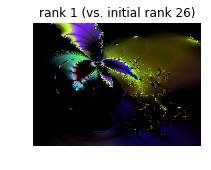

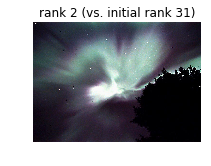

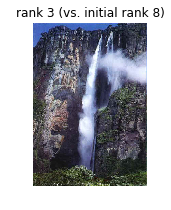

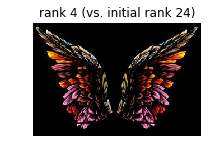

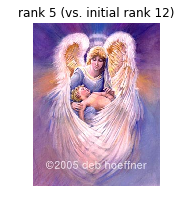

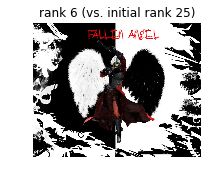

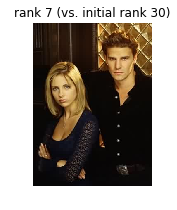

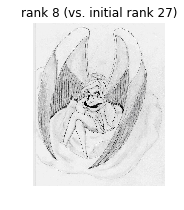

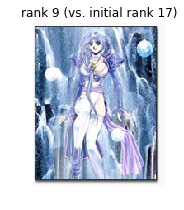

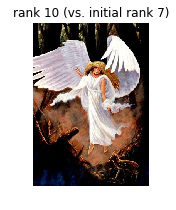

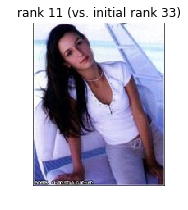

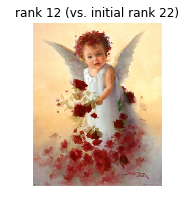

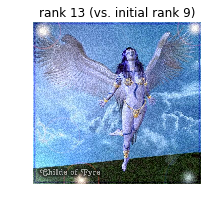

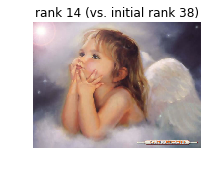

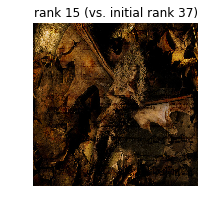

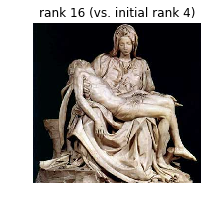

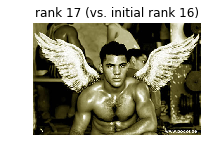

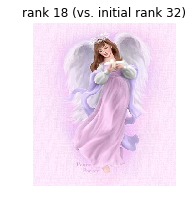

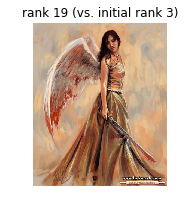

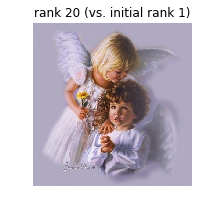

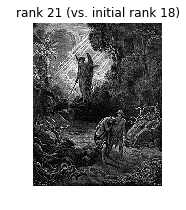

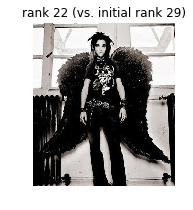

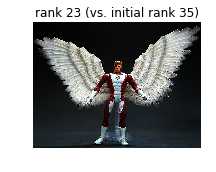

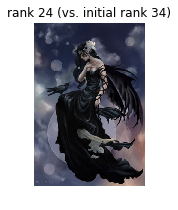

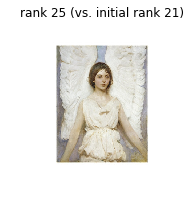

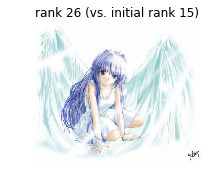

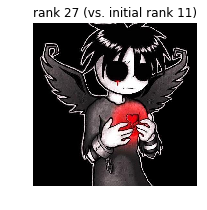

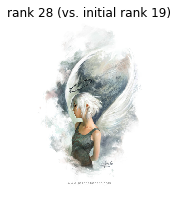

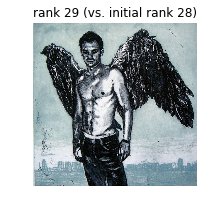

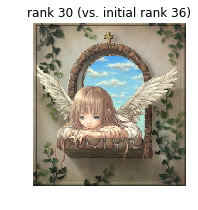

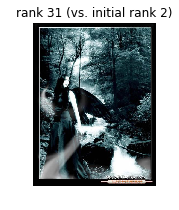

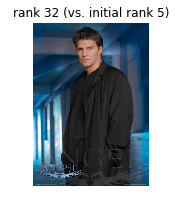

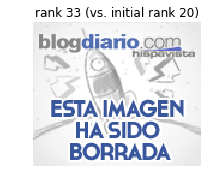

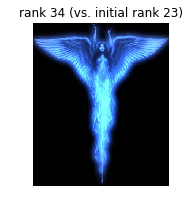

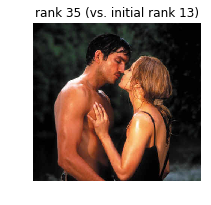

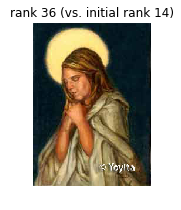

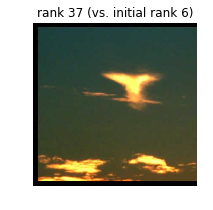

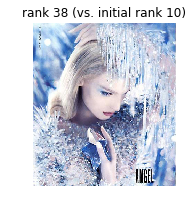

In [73]:
new_ranking = np.argsort(nrsv_n_scores) # replace rsv_n_scores by the scores you want to use as input!

for index in range(len(new_ranking)):
    image_path = category_data['image_paths'][new_ranking[index]]
    #print image_path
    image = cv2.imread(image_path)
    ipynb_show_cv2_image(image, 'rank %s (vs. initial rank %s)' % (index + 1, category_data['initial_ranks'][new_ranking[index]]), (3, 3))

## Your assignment
To demonstrate your completed assignment, please submit a file named [studentNumberMember1_studentNumberMember2.pdf] through the Dropbox link above. In this file, discuss your observations on how neighborhood voting mechanisms affect the ranking of images in the lab dataset. More specifically, focus on discussing the following questions:
- what is the impact of changing <i>k</i>?
- what is the impact of considering different visual features to base comparison on (i.e. edge histograms vs. HSV histograms)?
- what voting mechanisms strike you as particularly good or bad for the given image categories?
- do you notice major differences between different image categories, and can you explain these?

Please give at least 3 concrete examples supporting your answers, providing images or screenshots of results.